In [1]:
import numpy as np
import tensorflow as tf
import Loader
import Transformer
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"
plt.style.use('dark_background')

In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\Tim\anaconda3\envs\tenso

In [2]:
import pickle

In [11]:
s = "testing.trex"
print(s.split('.'))

['testing', 'trex']


In [7]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0,scaffold=True)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0,scaffold=True)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0,scaffold=True)

trainData, testData, valData = Transformer.normalizeData(compoundDataTrain, compoundDataTest, 
                                                         compoundDataValidate, newMean=0, newStd=1)

## SVM for Regression (aka SVR)

Ein Error:  0.3509346788950786
Eval Error:  2.509215397838561
Etest Error:  2.826566646665065


Text(0.5, 1.0, 'Test Predictions vs Actual')

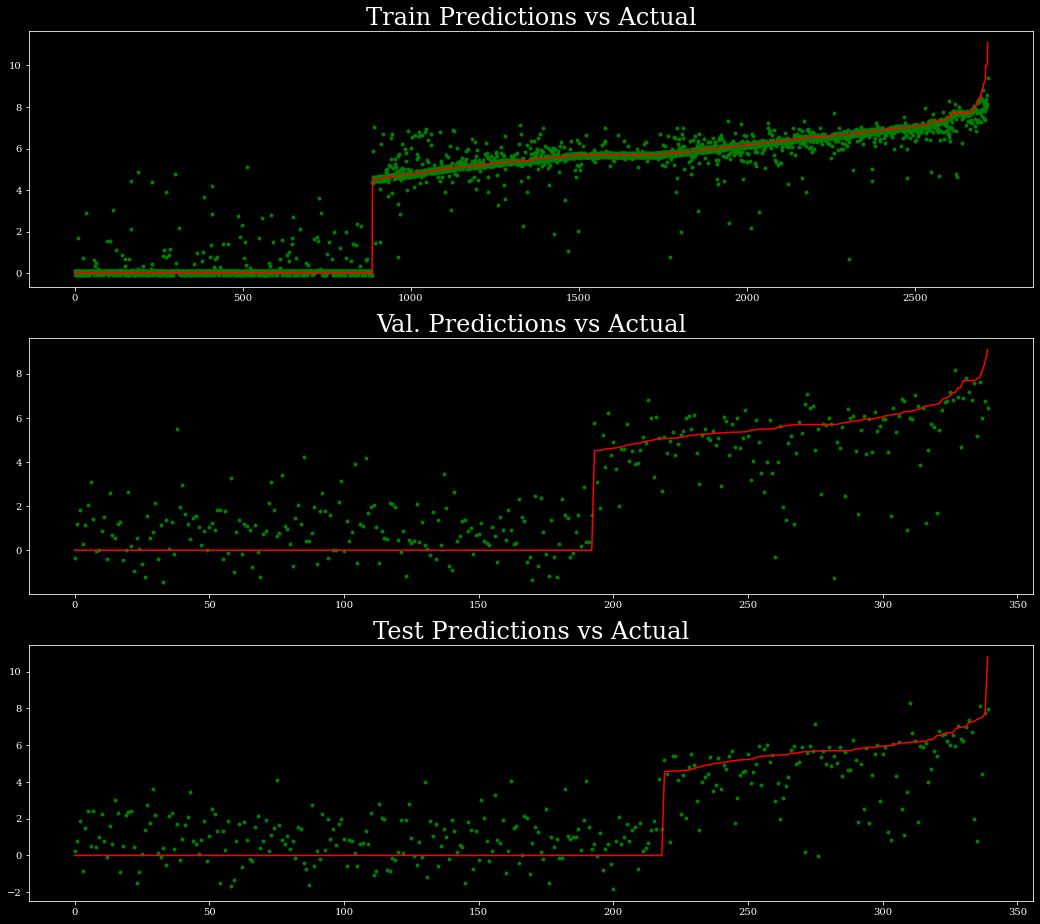

In [8]:
from sklearn import svm
from sklearn.metrics import mean_squared_error

maxC = 10
svrModel = svm.SVR(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    gamma='scale',                  # The kernel coefficient
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
)

svrModel.fit(trainData, activitiesTrain)
trainPred = svrModel.predict(trainData)
valPred = svrModel.predict(valData)
testPred = svrModel.predict(testData)

print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often


fig, ax = plt.subplots(3, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
testOrder = np.argsort(activitiesTest)
ax[0].plot(trainPred[trainOrder], "g.")
ax[0].plot(activitiesTrain[trainOrder], color="red")
ax[1].plot(valPred[valOrder], "g.")
ax[1].plot(activitiesValidate[valOrder], color="red")
ax[2].plot(testPred[testOrder], "g.")
ax[2].plot(activitiesTest[testOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[2].set_title("Test Predictions vs Actual", fontsize=24)

In [4]:
import ModelFile

ModelFile.save(svrModel, "svrRegr1.pkl", "Regression SVR, Ein Error:  0.3554315571414324" +
    "Eval Error:  2.215028194809491. See Regression Models (SVM and NN) jupyter file for details.")

In [3]:
import ModelFile

ModelFile.load("svrRegr1.pkl", verbose=True)

Model Description: 
Regression SVR, Ein Error:  0.3554315571414324Eval Error:  2.215028194809491. See Regression Models (SVM and NN) jupyter file for details.


SVR(C=10, tol=1e-05)

## NN Regression

In [9]:
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
inputDim = np.shape(trainData)[1] #how many inputs
#build and run model
    
nnRegrMod = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(350, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(150, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
    ])

nnRegrMod.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

history = nnRegrMod.fit(trainData, activitiesTrain, validation_data = (valData, activitiesValidate), 
    epochs=50, batch_size=10, verbose = 1) #verbose = 0 for no printing

Epoch 1/50
272/272 [==============================] - 1s 5ms/step - loss: 20.3477 - mean_squared_error: 4.2017 - val_loss: 13.5677 - val_mean_squared_error: 3.1609
Epoch 2/50
272/272 [==============================] - 1s 4ms/step - loss: 10.9749 - mean_squared_error: 2.4822 - val_loss: 11.3011 - val_mean_squared_error: 4.2693
Epoch 3/50
272/272 [==============================] - 1s 4ms/step - loss: 8.2455 - mean_squared_error: 2.1083 - val_loss: 7.8077 - val_mean_squared_error: 2.4281
Epoch 4/50
272/272 [==============================] - 1s 4ms/step - loss: 6.5532 - mean_squared_error: 1.7344 - val_loss: 7.7235 - val_mean_squared_error: 3.3936
Epoch 5/50
272/272 [==============================] - 1s 4ms/step - loss: 5.3401 - mean_squared_error: 1.4122 - val_loss: 6.2618 - val_mean_squared_error: 2.6706
Epoch 6/50
272/272 [==============================] - 1s 4ms/step - loss: 4.6299 - mean_squared_error: 1.3042 - val_loss: 5.7932 - val_mean_squared_error: 2.7136
Epoch 7/50
272/272 [====

Ein Error:  0.4492211722434153
Eval Error:  2.745841055245345
Etest Error:  404.8824645125414


Text(0.5, 1.0, 'Test Predictions vs Actual')

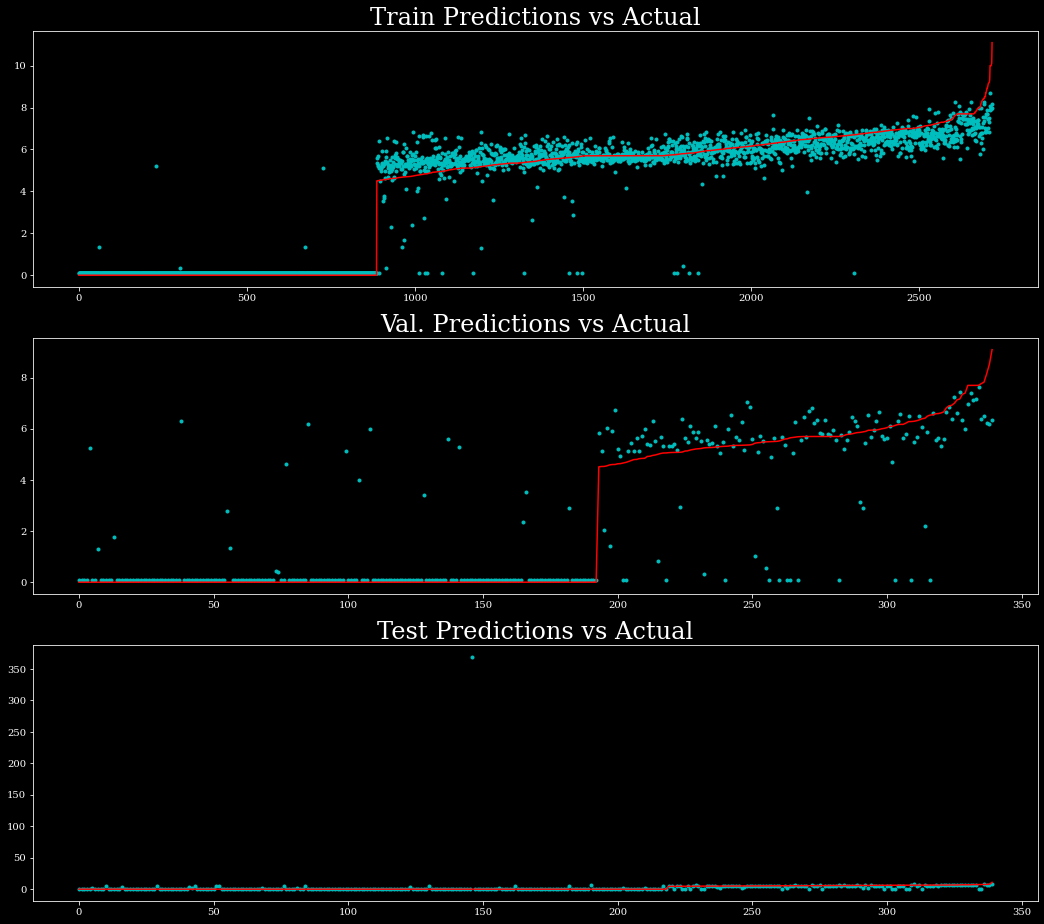

In [13]:
fig, ax = plt.subplots(3, figsize=(18,16))

trainPred = nnRegrMod.predict(trainData).flatten()
valPred = nnRegrMod.predict(valData).flatten()
testPred = nnRegrMod.predict(testData).flatten()

print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
testOrder = np.argsort(activitiesTest)
ax[0].plot(trainPred[trainOrder], "c.")
ax[0].plot(activitiesTrain[trainOrder], color="red")
ax[1].plot(valPred[valOrder], "c.")
ax[1].plot(activitiesValidate[valOrder], color="red")
ax[2].plot(testPred[testOrder], "c.")
ax[2].plot(activitiesTest[testOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[2].set_title("Test Predictions vs Actual", fontsize=24)

## Bah humbug, "mid" performance
New method, use SVM (our best predictor) for classification, then if classified as low activity give it a zero, otherwise use any high activity and then use svm (or more correctly SVR) to classify high activity, should reduce error significantly

In [8]:
compoundsTrain, smilesTrain, labelsTrain, compoundDataTrain, activitiesTrain = Loader.getTrain(defaultValue=0)
compoundsTest, smilesTest, labelsTest, compoundDataTest, activitiesTest = Loader.getTest(defaultValue=0)
compoundsValidate, smilesValidate, labelsValidate, compoundDataValidate, activitiesValidate = Loader.getValidate(defaultValue=0)

trainData, testData, valData = Transformer.normalizeData(compoundDataTrain, compoundDataTest, 
                                                         compoundDataValidate, newMean=0, newStd=1)

trainClass = Transformer.toBinaryClassification(activitiesTrain)
testClass = Transformer.toBinaryClassification(activitiesTest)
valClass = Transformer.toBinaryClassification(activitiesValidate)

In [9]:
#create svm model
from sklearn import svm
from sklearn.metrics import accuracy_score

maxC = 10
binModel =svm.SVC(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
    break_ties=False,               # How to handle breaking ties
)
binModel.fit(trainData, trainClass) #binary classification using svm

highActMask = trainClass == 1 #all the high activity data points

#now run an SVR on the high activity data
maxC = 1
regModel = svm.SVR(
    C=maxC,                          # The regularization parameter (default 1)
    kernel='rbf',                   # The kernel type used (RBF: Gaussian Kernel Radial Basis Function)
    gamma='scale',                  # The kernel coefficient
    tol=0.00001,                    # Stopping crierion
    cache_size=200,                 # Size of kernel cache
    verbose=False,                  # Enable verbose output
    max_iter= -1,                   # Hard limit on iterations (-1 is no limit)
)
regModel.fit(trainData[highActMask], activitiesTrain[highActMask]); #regression model only on high activity

In [10]:
#alternate regression model
from sklearn import preprocessing
from sklearn import model_selection
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.losses import MeanSquaredError

l1Reg = keras.regularizers.L1(.001)
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False
)
inputDim = np.shape(trainData)[1] #how many inputs
#build and run model
    
nnRegr = tf.keras.models.Sequential([
        tf.keras.layers.Dense(inputDim, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(350, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(400, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(300, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(250, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(150, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(50, activation='relu', kernel_regularizer = l1Reg),
        tf.keras.layers.Dense(1, activation='relu', kernel_regularizer = l1Reg)
    ])

nnRegr.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['MeanSquaredError'])

highActMask = trainClass == 1 #all the high activity data points

history = nnRegr.fit(trainData[highActMask], activitiesTrain[highActMask], 
    epochs=50, batch_size=5, verbose = 1) #verbose = 0 for no printing

Epoch 1/50
337/337 [==============================] - 6s 10ms/step - loss: 19.1870 - mean_squared_error: 2.4960
Epoch 2/50
337/337 [==============================] - 3s 10ms/step - loss: 10.6240 - mean_squared_error: 0.8515
Epoch 3/50
337/337 [==============================] - 3s 10ms/step - loss: 7.5558 - mean_squared_error: 0.6648
Epoch 4/50
337/337 [==============================] - 4s 11ms/step - loss: 5.5127 - mean_squared_error: 0.5292
Epoch 5/50
337/337 [==============================] - 4s 12ms/step - loss: 4.1363 - mean_squared_error: 0.5113
Epoch 6/50
337/337 [==============================] - 4s 11ms/step - loss: 3.1408 - mean_squared_error: 0.5103
Epoch 7/50
337/337 [==============================] - 3s 10ms/step - loss: 2.3983 - mean_squared_error: 0.4808
Epoch 8/50
337/337 [==============================] - 3s 9ms/step - loss: 1.8991 - mean_squared_error: 0.4817
Epoch 9/50
337/337 [==============================] - 4s 12ms/step - loss: 1.5417 - mean_squared_error: 0.4761


In [16]:
def evalData(inputData, svmModel, svrModel, zeroGuess=0): #given the models and data points evaluate
    finalPred = np.ones(len(inputData))*zeroGuess #how many predictions we should have
    binaryClass = svmModel.predict(inputData)
    
    regrPredict = svrModel.predict(inputData[binaryClass == 1]) #regression high activity prediction
    finalPred[binaryClass == 1] = regrPredict #set the high activity guesses, otherwise 0
    return finalPred

def evalData2(inputData, svmModel, nnModel, zeroGuess=0): #same as above but use NN for regr
    finalPred = np.ones(len(inputData))*zeroGuess #how many predictions we should have
    binaryClass = svmModel.predict(inputData)
    
    regrPredict = nnModel.predict(inputData[binaryClass == 1]).flatten() #high activity regr predict
    finalPred[binaryClass == 1] = regrPredict #set the high activity guesses, otherwise 0
    return finalPred
    
zGuess = .7
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess)
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

trainPred2 = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess)
valPred2 = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

print("SVR:")
print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred))
print('\nNN:')
print("Ein Error: ", mean_squared_error(activitiesTrain, trainPred2))
print("Eval Error: ", mean_squared_error(activitiesValidate, valPred2))

#only if we're testing test data
#print("Etest Error: ", mean_squared_error(activitiesTest, testPred)) #DO NOT Run this often

SVR:
Ein Error:  0.36545717829478813
Eval Error:  2.2556840382932357

NN:
Ein Error:  0.4018728496312559
Eval Error:  2.33258814841824


In [20]:
print(np.mean(activitiesTrain[activitiesTrain > 4]))

5.99159657462886


## Figure out the best constant guess
Or just use math: https://www.desmos.com/calculator/hz7dfu92wr

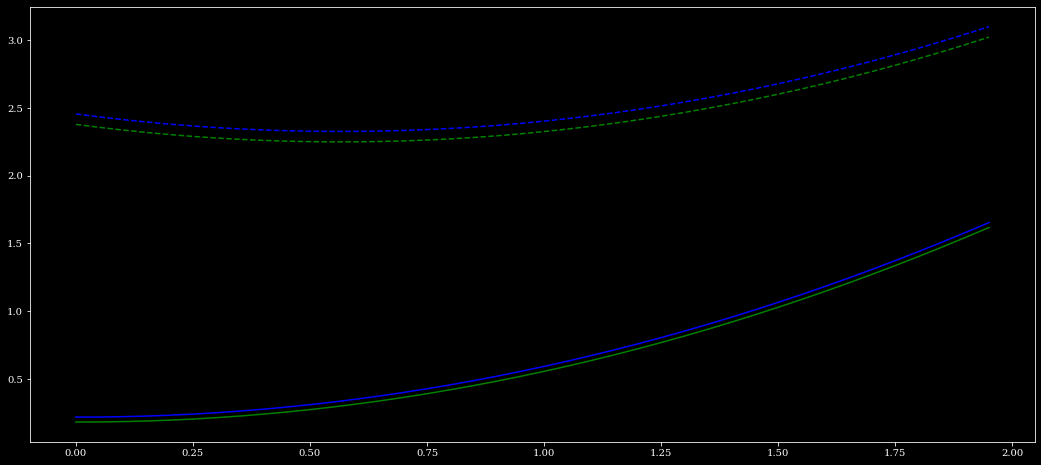

In [14]:
zGuesses = np.arange(0,2,.05)
trainErrorS = [] #SVM regr
valErrorS = [] #SVM regr
trainErrorN = [] #NN regr
valErrorN = [] #NN regr

for zG in zGuesses:
    trainPredS = evalData(trainData, binModel, regModel, zeroGuess=zG)
    valPredS = evalData(valData, binModel, regModel, zeroGuess=zG)
    trainPredN = evalData2(trainData, binModel, nnRegr, zeroGuess=zG)
    valPredN = evalData2(valData, binModel, nnRegr, zeroGuess=zG)
    
    trainErrorS.append(mean_squared_error(activitiesTrain, trainPredS))
    valErrorS.append(mean_squared_error(activitiesValidate, valPredS))
    trainErrorN.append(mean_squared_error(activitiesTrain, trainPredN))
    valErrorN.append(mean_squared_error(activitiesValidate, valPredN))
    
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(zGuesses, trainErrorS, color="green")
ax.plot(zGuesses, valErrorS, color="green", linestyle="dashed")
ax.plot(zGuesses, trainErrorN, color="blue")
ax.plot(zGuesses, valErrorN, color="blue", linestyle="dashed")

## Getting an idea of prediction accuracy

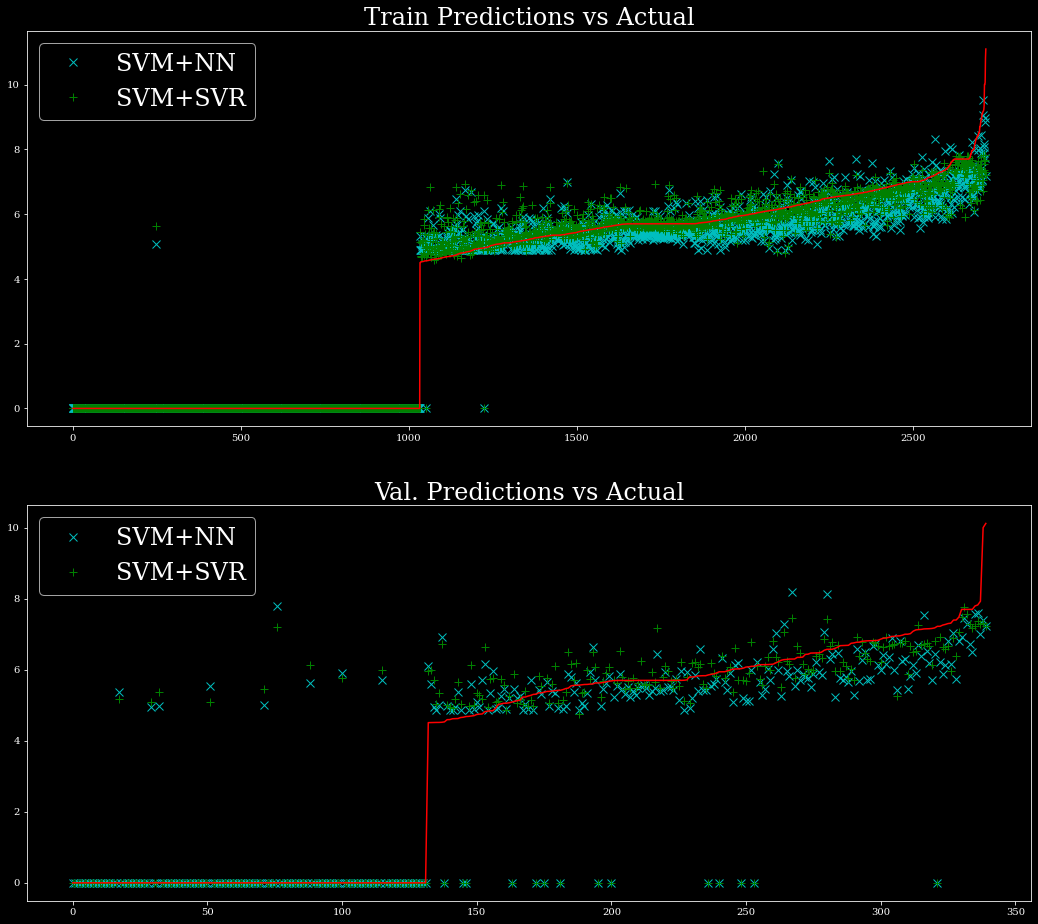

In [12]:
zGuess = 0
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess)
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)
#testPred = evalData(testData, binModel, regModel)

trainPred2 = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess)
valPred2 = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred2[trainOrder], "cx", ms=8, label="SVM+NN")
ax[0].plot(trainPred[trainOrder], "g+", ms=8, label="SVM+SVR")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred2[valOrder], "cx", ms=8, label="SVM+NN")
ax[1].plot(valPred[valOrder], "g+", ms=8, label="SVM+SVR")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

## Comparing the two
First SVR vs SVM + SVR
Then NN vs SVM + NN

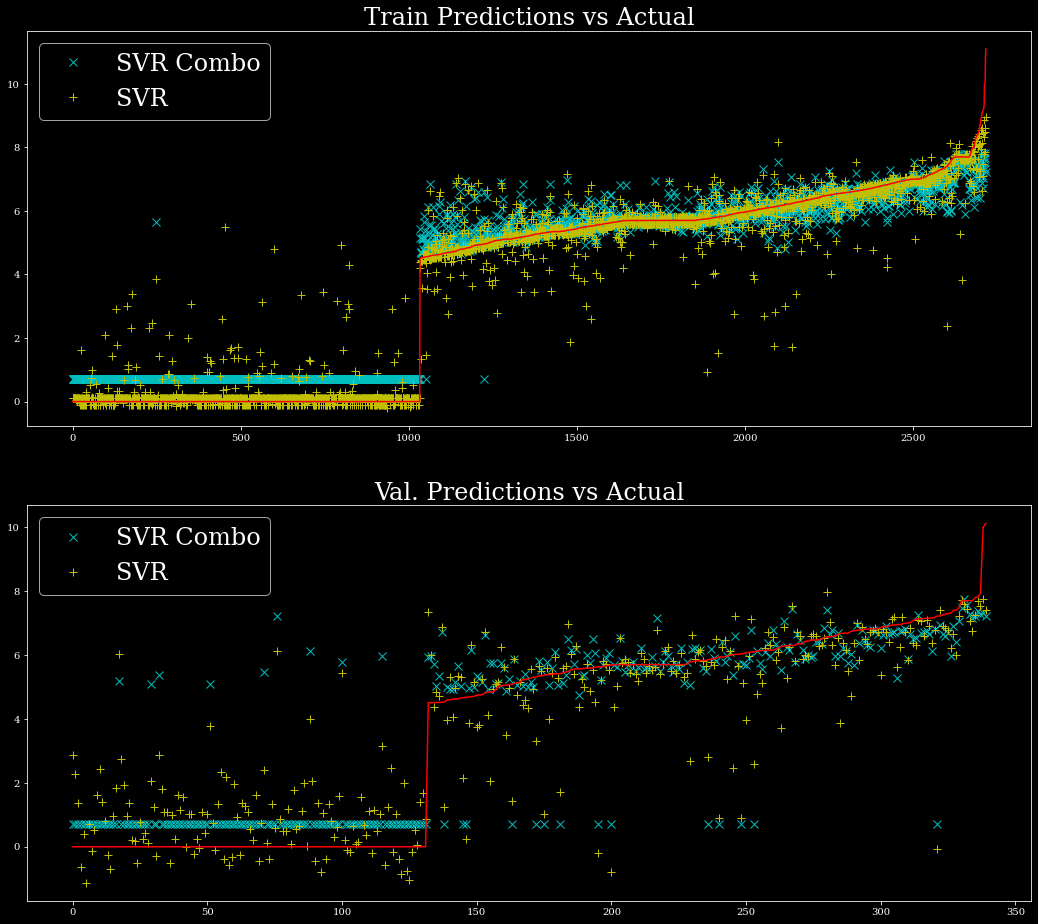

In [17]:
trainPred = evalData(trainData, binModel, regModel, zeroGuess=zGuess) #SVM + SVR
valPred = evalData(valData, binModel, regModel, zeroGuess=zGuess)

trainPred2 = svrModel.predict(trainData) #Just SVM
valPred2 = svrModel.predict(valData)

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], "cx", ms=8, label="SVR Combo")
ax[0].plot(trainPred2[trainOrder], "y+", ms=8, label="SVR")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred[valOrder], "cx", ms=8, label="SVR Combo")
ax[1].plot(valPred2[valOrder], "y+", ms=8, label="SVR")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

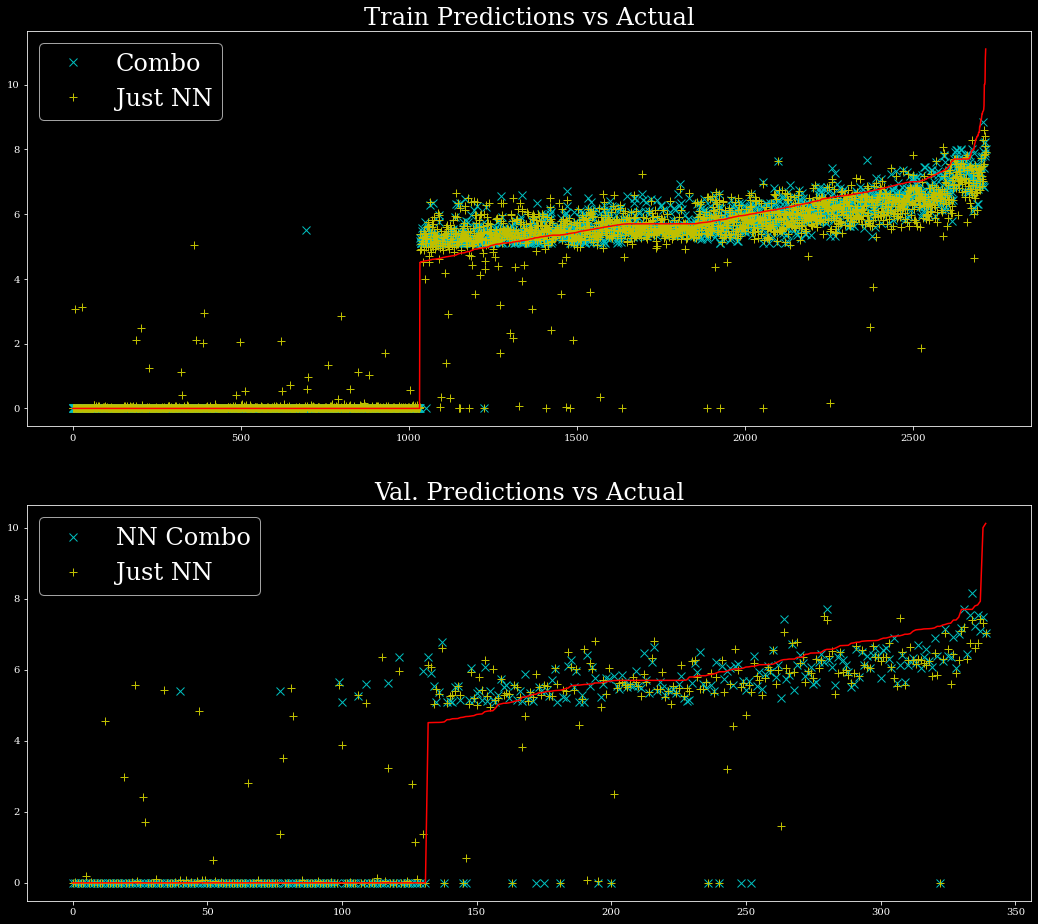

In [45]:
trainPred = evalData2(trainData, binModel, nnRegr, zeroGuess=zGuess) #SVM + NN regr
valPred = evalData2(valData, binModel, nnRegr, zeroGuess=zGuess)

trainPred2 = nnRegrMod.predict(trainData).flatten() #Just NN
valPred2 = nnRegrMod.predict(valData).flatten()

fig, ax = plt.subplots(2, figsize=(18,16))

trainOrder = np.argsort(activitiesTrain)
valOrder = np.argsort(activitiesValidate)
ax[0].plot(trainPred[trainOrder], "cx", ms=8, label="Combo")
ax[0].plot(trainPred2[trainOrder], "y+", ms=8, label="Just NN")
ax[0].plot(activitiesTrain[trainOrder], color="red")

ax[1].plot(valPred[valOrder], "cx", ms=8, label="NN Combo")
ax[1].plot(valPred2[valOrder], "y+", ms=8, label="Just NN")
ax[1].plot(activitiesValidate[valOrder], color="red")

ax[0].set_title("Train Predictions vs Actual", fontsize=24)
ax[1].set_title("Val. Predictions vs Actual", fontsize=24)
ax[0].legend(fontsize=24)
ax[1].legend(fontsize=24)

In [55]:
#just github pushing code

#!git add -A && git commit -m "Decent regression model" && git push

Enumerating objects: 15, done.
Counting objects: 100% (15/15), done.
Delta compression using up to 8 threads
Compressing objects: 100% (8/8), done.
Writing objects: 100% (8/8), 1.86 MiB | 3.78 MiB/s, done.
Total 8 (delta 5), reused 0 (delta 0)
remote: Resolving deltas: 100% (5/5), completed with 5 local objects.
To https://github.com/timothylindsey/Biola-Lawrence-Livermore-Project
   6f54b4c..0e1d169  main -> main


## Save the models

In [21]:
import ModelFile

messageStart = "See Regression Models (SVR and NN) code file. Used for a combo regression model, svm used for binary classification, then either SVR or NN for regression of high activity model. Use constant guess of about .7 for best mean square error. "
ModelFile.save(binModel, "comboRegrSVM.pkl", messageStart + "This is the SVM Portion.")
ModelFile.save(regModel, "comboRegrSVR.pkl", 
               messageStart + "This is the SVR option for regr of high activity.")
ModelFile.save(nnRegr, "comboRegrNN.h5", 
               messageStart + "This is the NN Portion for regr of high activity.")